In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
data_path = os.getenv('DATA_PATH')
result_path = os.getenv('RESULT_PATH')

'/disks/qnap3/users/23-miura/coauth-interest'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import random
from scipy.stats import expon
from scipy.stats import pareto
import os

from util import plotter

In [50]:
# partitions = pd.read_pickle(result_path+"/partitions.pickle")
year_df = pd.DataFrame(pd.read_pickle(data_path+"/paper_detail/year.pickle")).sort_values(by="year",ascending=True)
year_df.head()

,year
eid,
14929032,1970
14878212,1970
14852370,1970
14865167,1970
14878213,1970


In [61]:
d = "PM"
authors_valid= pd.read_pickle(result_path+f"/authors_valid_{d}.pickle")
sample_authors = pd.read_pickle(result_path+f"/sample_authors_{d}.pickle")

# authors_valid_sorted = authors_valid.set_index("authid",inplace=False)
# authors_valid_sorted.head()
# authors_valid_sorted.loc[[55323498300]]

,eid,authseq,indexname,surname,givenname,doctype,partition
authid,,,,,,,
55323498300,84936993481,4,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,85021626869,4,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,5544306192,5,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,84934892826,3,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,34147138950,1,Ahmed S.,Ahmed,Shakeel,ar,3.0
...,...,...,...,...,...,...,...
55323498300,84969250859,5,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,84944064336,4,Ahmed S.,Ahmed,Shakeel,ar,3.0
55323498300,344120751,4,Ahmed S.,Ahmed,Shakeel,cp,3.0


In [68]:
def exists_first_authorship(series):
    for i, value in enumerate(series['authseq']):
        if value == 1:
            return True
        elif value !="" :
            return False
    return False

def calculate_coauth_intervals(id,authors_valid,year_df):
    works = authors_valid['eid'][authors_valid['authid']==id]
    if works.shape[0]<3: return None

    selected_papers = year_df[year_df.index.isin(works.values)]
    selected_papers = selected_papers.assign(seq=list(range(0,len(selected_papers))))
    coauthors = authors_valid[authors_valid['eid'].isin(works)].query(f"authid!={id}")
    
    df_seqyear = pd.merge(coauthors,selected_papers, how='left', on='eid').sort_values(by='seq')
    df_seqyear_multi = df_seqyear.groupby(by='authid', group_keys=True).filter(lambda x: len(x) > 1)
    if len(df_seqyear_multi) < 1: return None
    df_seqyear_delta = df_seqyear_multi.groupby(by='authid', group_keys=True)[['year','seq']] \
    .apply(lambda x:  x - x.shift(1)) \
    .dropna().astype(int).reset_index()
    
    df_seqyear_delta = pd.merge(df_seqyear_delta, df_seqyear["eid"], how="left", left_on="level_1", right_index=True).drop(columns=["level_1"])
    df_seqyear_delta["source_authid"] = id
    df_seqyear_delta["previous_work"] = df_seqyear_delta.groupby("authid").shift(1)["eid"]

    df_seqyear_delta = df_seqyear_delta.dropna()
    return df_seqyear_delta

num_iterations = 100
batch_size = 1000

# disciplines = partitions["name"]
# for d in disciplines:

import tqdm

for i in tqdm.tqdm(range(num_iterations)):
    result = pd.DataFrame()
    for j in range(batch_size):
        result = pd.concat([result, calculate_coauth_intervals(sample_authors[i+j*batch_size],authors_valid,year_df)],axis=0)
    result.to_pickle(result_path+f"/temp/{d}_{i:02}.pickle")

auth = pd.concat([pd.read_pickle(result_path+f"/temp/{d}_{i:02}.pickle") for i in range(0,num_iterations)],axis=0)
auth.to_pickle(result_path+f"/{d}_100k.pickle")

  0%|                                                   | 0/100 [00:00<?, ?it/s]

This is taking too long, we give up.



  8%|██▉                                 | 8/100 [2:55:44<35:51:52, 1403.40s/it]

## Inspect Result

In [ ]:
for i,d in enumerate(disciplines):
    auth = pd.read_pickle(f"./result/{d}_100k.pickle")
    # auth = pd.concat([pd.read_pickle(f"./result/{disc}_{i:02}.pickle") for i in range(70,100)],axis=0)
    print("In ",d,":...#Unique Authors Examined: ",len(auth["source_authid"].unique())) # number of unique authors examined
    print("...aggregatedly coauth with ",len(auth["authid"].unique()),"unique researchers") # number of unique authors of 100k researcher did coauthor
    print("...aggregatedly produced",len(auth["eid"].unique()),"papers") # number of unique papers of 100k researcher did coauthor

    color = plt.cm.viridis(i / (len(disciplines) - 1))
    # color = "blue"
    unique_coauth_researchers = auth.groupby("source_authid")["authid"].apply(lambda x: len(x.unique()))
    plotter(unique_coauth_researchers,\
            u="people",\
            count="probability",\
            plot="log",
            l=d,\
            title="Distribution - number of unique auth pairs",\
            c=color,\
            line=True,\
            xlabel="number of unique auth pairs")
    plt.ylim(top=0.3)
    print("Average researcher coauth with ",round(unique_coauth_researchers.mean(),2),"researchers on average") # average number of unique coauthor per researcher
    print("Average researcher coauth ",round(len(auth)/len(auth["source_authid"].unique()),2)," times in total") # average number of re-coauthorships per researcher
    print("Coauth persist ", round(len(auth)/(len(auth["source_authid"].unique())*unique_coauth_researchers.mean()),2)," times on average") # average number of re-coauthorships per researhcer per unique coauthor

## plot

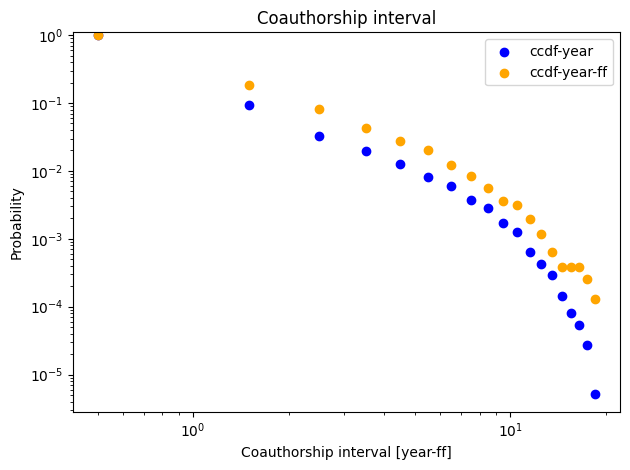

In [ ]:
plotter(result.query("year>0")['year'].values,"Coauthorship interval",'blue', "year",plot="power-law")
plotter(result.query("is_ff==True and year>0")['year'].values,"Coauthorship interval",'orange', "year-ff",plot="power-law")

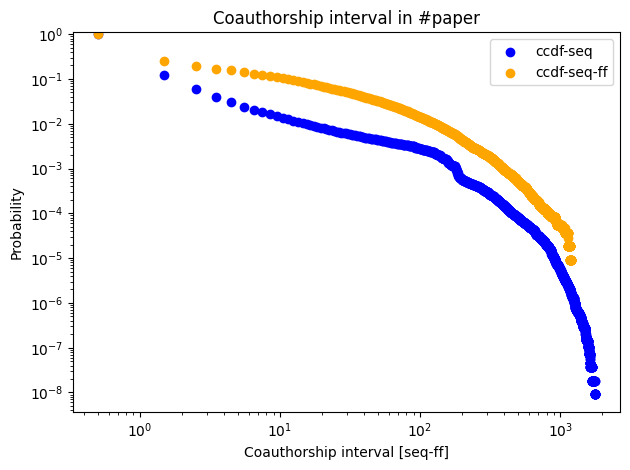

In [ ]:
plotter(result.query("seq>0")['seq'].values,"Coauthorship interval in #paper",'blue', "seq",plot="power-law")
plotter(result.query("is_ff==True  and seq>0")['seq'].values,"Coauthorship interval in #paper",'orange', "seq-ff",plot="power-law")

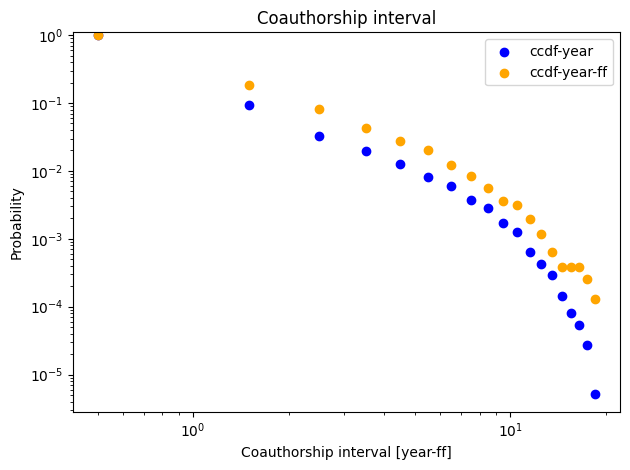

In [ ]:
plotter(result.query("year>0")['year'].values,"Coauthorship interval",'blue', "year",plot="power-law")
plotter(result.query("is_ff==True and year>0")['year'].values,"Coauthorship interval",'orange', "year-ff",plot="power-law")

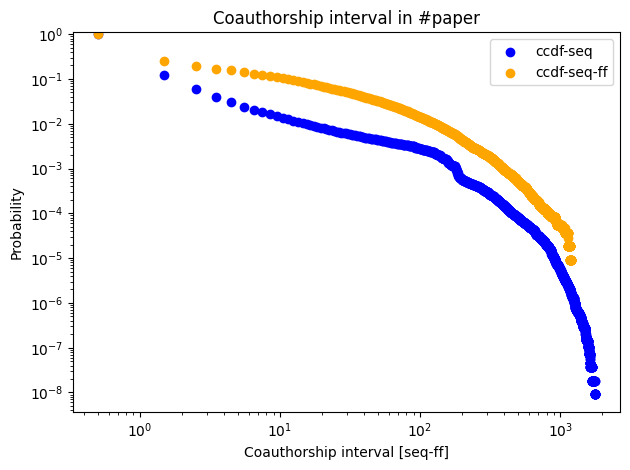

In [ ]:
plotter(result.query("seq>0")['seq'].values,"Coauthorship interval in #paper",'blue', "seq",plot="power-law")
plotter(result.query("is_ff==True  and seq>0")['seq'].values,"Coauthorship interval in #paper",'orange', "seq-ff",plot="power-law")